## Importar lo importante

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
import tfe
from geopy.distance import vincenty
from itertools import chain, combinations
import random
import scipy as sp

## Funciones Auxiliares

In [2]:
#Función que filtra columnas de acuerdo a una lista de indices
#filter_features: matrix list -> matrix
def filter_features(vector,selected_features):
    selected = []
    for i in range(len(selected_features)):
        selected.append(features_dict[selected_features[i]])
    return vector[:,selected]

In [29]:
def only_one_match_home_and_work(rois_a,limit,shared_rois):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        neighbours = get_neighbours_index(rois_a[i],shared_rois,i,2)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [30]:
def random_match_home_and_work(rois_a,limit,shared_rois):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        neighbours = get_neighbours_index(rois_a[i],shared_rois,i,2)
        n_neighbours = len(neighbours)
        if n_neighbours > 0:
            if n_neighbours == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                random_neighbour = random.choice(neighbours)
                a_matrix[i,random_neighbour] = 0
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [5]:
def compare_vectors_with_neighbours(vector_a,vector_b,rois_a,rois_b,shared_rois,limit,min_shared,f_normalizar,f_distancia):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        #print "Usuario ",i
        rois_abril = rois_a[i]
        neighbours = get_neighbours_index(rois_abril,shared_rois,i,min_shared)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                a_sequence = vector_a[i,:]
                b_sequences = vector_b[neighbours,:]
                ab_sequences = np.vstack((a_sequence,b_sequences))
                for j in range(ab_sequences.shape[1]):
                    ab_sequences[:,j] = f_normalizar(ab_sequences[:,j])
                counter = 0
                for neighbour in neighbours:
                    dist = f_distancia(np.asarray(ab_sequences[0,:]),np.asarray(ab_sequences[counter+1,:]))
                    a_matrix[i,neighbour] = -dist
                    counter += 1
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [81]:
def compare_vectors_with_neighbours_normalized(vector_a,vector_b,rois_a,rois_b,shared_rois,limit,min_shared,f_dist):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        #print "Usuario ",i
        rois_abril = rois_a[i]
        neighbours = get_neighbours_index(rois_abril,shared_rois,i,min_shared)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                a_sequence = vector_a[i,:]
                b_sequences = vector_b[neighbours,:]
                ab_sequences = np.vstack((a_sequence,b_sequences))
                counter = 0
                for neighbour in neighbours:
                    dist = f_dist(np.asarray(ab_sequences[0,:]),np.asarray(ab_sequences[counter+1,:]))
                    a_matrix[i,neighbour] = -dist
                    counter += 1
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [7]:
def get_n_correct(a_matrix,limit):
    identified_indexs = [] #almacena los indices de que secuencia fue seleccionada como match
    wrong_indexs = [] # almacena los indices de los que se clasificaron incorrectamente
    correct_indexs = [] # almacena los indices de los que se clasificaron correctamente
    selected_distance = [] # almacena la distancia de los seleccionados
    abstenidos = []
    n_identified = 0
    for i in range(limit):
        the_index = np.argmax(a_matrix[:,i])
        selected_distance.append(a_matrix[the_index,i])
        identified_indexs.append(the_index)
        if a_matrix[the_index,i] == -1:
            abstenidos.append(the_index)
        elif(the_index!=i):
            wrong_indexs.append(the_index)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
    return [n_identified,selected_distance,identified_indexs,abstenidos]


In [8]:
#normalizar: [float] -> [float(0,1)]
#Normalizacion mayor menor
def normalizar_min_max(vector):
    a_max = np.max(vector)
    a_min = np.min(vector)
    if a_max == 0 and a_min == 0:
        return vector
    #if a_max == 0:
     #   a_max= a_min*0.0000001
    for i in range(len(vector)):
        vector[i] = (vector[i] - a_min)/a_max
    return vector    

In [58]:
#normalizar: [float] -> [float(0,1)]
#Normalizacion mayor menor
def normalizar_norma(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector 
    return vector / np.linalg.norm(vector)

In [17]:
#get_neighbours_index: np.matrix int -> np.array
#obtiene los vecinos del usuario "user",
#considerando como vecino a quien comparte dos ubicaciones
def get_neighbours_index(rois_a,shared_rois,user,min_shared):
    min_shared_x = min(len(rois_a),min_shared)
    neighbours = np.where(shared_rois[user] >= min_shared_x)
    return neighbours[0]

## Obtener datos

In [10]:
with open('data/shared_rois_and_min_distance.pickle') as f:
    shared_rois = pickle.load(f)
    min_distance = pickle.load(f)

In [11]:
with open('data/feature_data.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [12]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [13]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

In [14]:
shared_1_rois_2_month = 0
shared_2_rois_2_month = 0
for i in range(limit):
    if shared_rois[i,i] > 0:
        shared_1_rois_2_month += 1
    if shared_rois[i,i] > 1:
        shared_2_rois_2_month += 1
print "% de tarjetas que comparten un roi en ambos meses:",str(round(shared_1_rois_2_month*100/limit,2)) + "%"
print "% de tarjetas que comparten dos roi en ambos meses:", str(round(shared_2_rois_2_month*100/limit,2)) + "%"

% de tarjetas que comparten un roi en ambos meses: 93.38%
% de tarjetas que comparten dos roi en ambos meses: 54.85%


### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [18]:
n_of_neighbours = []
for i in range(limit):
    n_of_neighbours.append(len(get_neighbours_index(abril_the_rois,shared_rois,i,2)))

(array([ 1051.,  1642.,   808.,   431.,   263.,   191.,   116.,    91.,
          117.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

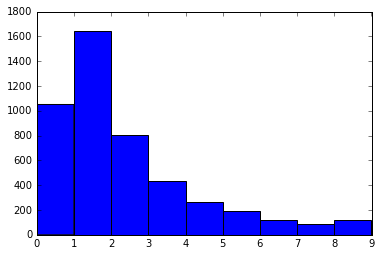

In [19]:
plt.hist(n_of_neighbours,range(10))

### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [328]:
n10_of_neighbours = filter(lambda x: x>9,n_of_neighbours)

(array([ 269.,  109.,   36.,    8.,    8.,    8.,    5.,    4.,    1.,
           0.,    0.,    1.,    2.,    1.,    0.,    0.,    0.,    0.,
           1.,    0.,    2.,    0.,    0.,    1.,    1.,    0.,    1.,
           0.,    0.,    1.]),
 array([  10.        ,   19.06666667,   28.13333333,   37.2       ,
          46.26666667,   55.33333333,   64.4       ,   73.46666667,
          82.53333333,   91.6       ,  100.66666667,  109.73333333,
         118.8       ,  127.86666667,  136.93333333,  146.        ,
         155.06666667,  164.13333333,  173.2       ,  182.26666667,
         191.33333333,  200.4       ,  209.46666667,  218.53333333,
         227.6       ,  236.66666667,  245.73333333,  254.8       ,
         263.86666667,  272.93333333,  282.        ]),
 <a list of 30 Patch objects>)

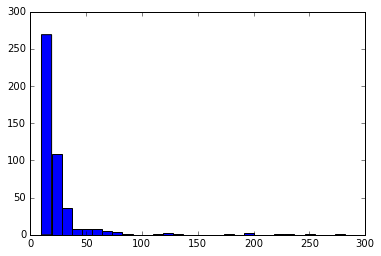

In [329]:
plt.hist(n10_of_neighbours,30)

## Feature Exploration

In [48]:
N_FEATURES = 19

In [20]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [21]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

In [55]:
feature_min_max = np.ones((4,N_FEATURES))
for feature in range(abril_vectors.shape[1]):
    feature_min_max[:,feature] = [min(abril_vectors[feature]),min(septiembre_vectors[feature]), max(abril_vectors[feature]),\
                                   max(septiembre_vectors[feature])]
    
feature_min_max_df = pd.DataFrame(feature_min_max)    
feature_min_max_df.index = ["min_abril","min_sept","max_abril","max_sept"]
feature_min_max_df.columns = features_names
feature_min_max_df

,msal,mlal,kmDistance,kmMaxDist,kmMinDist,rg,unc_entropy,random_entropy,p100_diff_last_origin,p100_diff_first_origin,card_type,start_time,end_time,traveled_days,traveled_days_bs,frequence_regularity,p100_exclusive_bus_days,p100_exclusive_metro_days,P100_bus_trips
min_abril,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
min_sept,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
max_abril,67229,64806,63735,56383,66933,62618,66372,54879,61621,51861,73504,71853,74677,60732,68207,45172,77776,68167,57114
max_sept,67797,57012,71085,65188,62837,62151,60960,72503,63535,54962,73814,68407,55748,63399,60512,61810,81971,68809,58159


## Seleccionar Features para la comparación

In [22]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin",\
    "start_time","end_time","traveled_days","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]


In [23]:
#selected_features = features_names

In [24]:
len(selected_features)

17

In [25]:
abril_selected_features = filter_features(abril_vectors,selected_features)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features)

## Normalizar con respecto a los vecinos

In [26]:
abril_selected_features.shape

(5169L, 17L)

## Hacer las comparaciones

### Seleccionar solo los que se tiene un match

In [31]:
a_matrix_unique_match = only_one_match_home_and_work(abril_the_rois,limit,shared_rois)

0.0780000686646


In [32]:
n_identified_unique_match,selected_distance_unique_match,identified_indexs_unique_match,abstenidos_unique_match = get_n_correct(a_matrix_unique_match,limit)

In [33]:
porcentaje_correcto_unique_match = n_identified_unique_match*100/limit
print str(round(porcentaje_correcto_unique_match,2))+ "%"

21.88%


### Seleccionar randommente entre los vecinos que matchean hogar y trabajo

In [34]:
a_matrix_random_match = random_match_home_and_work(abril_the_rois,limit,shared_rois)

0.0789999961853


In [35]:
n_identified_random_match,selected_distance_random_match,identified_indexs_random_match,abstenidos_random_match = get_n_correct(a_matrix_random_match,limit)

In [36]:
porcentaje_correcto_random_match = n_identified_random_match*100/limit
print str(round(porcentaje_correcto_random_match,2))+ "%"

29.0%


### Seleccionar con distancia euclidiana entre los vecinos con norma minmax

In [62]:
a_matrix = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.euclidean)

1.80500006676


In [63]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [64]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

35.46%


In [40]:
len(abstenidos)

2149

### Seleccionar con distancia euclidiana entre los vecinos con norma norm

In [59]:
a_matrix = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,normalizar_norma,sp.spatial.distance.euclidean)

1.84200000763


In [60]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [61]:
porcentaje_correcto = n_identified*100/limit
print "Por"+str(round(porcentaje_correcto,2))+ "%"

33.16%


### Seleccionar con distancia euclidiana entre los vecinos con las features ya normalizadas con norma

In [72]:
abril_norm_vectors = np.ones((limit, N_FEATURES))
septiembre_norm_vectors = np.ones((limit, N_FEATURES))
for i in range(abril_selected_features.shape[1]):
    abril_norm_vectors[:,i] = normalizar_norma(abril_selected_features[:,i])
    septiembre_norm_vectors[:,i] = normalizar_norma(septiembre_selected_features[:,i])

In [74]:
a_matrix = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.euclidean)

0.37700009346


In [75]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [76]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

44.61%


### Seleccionar con distancia euclidiana entre los vecinos con las features ya normalizadas con min max

In [77]:
abril_norm_vectors = np.ones((limit, N_FEATURES))
septiembre_norm_vectors = np.ones((limit, N_FEATURES))
for i in range(abril_selected_features.shape[1]):
    abril_norm_vectors[:,i] = normalizar(abril_selected_features[:,i])
    septiembre_norm_vectors[:,i] = normalizar(septiembre_selected_features[:,i])

In [78]:
a_matrix = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.euclidean)

0.388000011444


In [79]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [80]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

44.84%


### Pruebas con diferentes distancias con normalización entre vecinos y normalizacion general

In [ ]:
abril_norm_vectors = np.ones((limit, N_FEATURES))
septiembre_norm_vectors = np.ones((limit, N_FEATURES))
for i in range(abril_selected_features.shape[1]):
    abril_norm_vectors[:,i] = normalizar_norma(abril_selected_features[:,i])
    septiembre_norm_vectors[:,i] = normalizar_norma(septiembre_selected_features[:,i])

#### Euclidiana

In [89]:
a_matrix_euclidiana = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,\
                                                      septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.euclidean)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_euclidiana,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist Euclidiana con norma minmax entre vecinos: "+str(round(porcentaje_correcto,2))+ "%"

1.53100013733
Dist Euclidiana con norma minmax entre vecinos: 33.43%


In [88]:
a_matrix_euclidiana = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.euclidean)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_euclidiana,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist Euclidiana con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"

0.74799990654
Dist Euclidiana con norma minmax general: 44.84%


#### Manhattan

In [90]:
a_matrix_manhattan = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,\
                                                     abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                     normalizar,sp.spatial.distance.cityblock)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_manhattan,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist manhattan con norma minmax entre vecinos: "+str(round(porcentaje_correcto,2))+ "%"

1.23399996758
Dist manhattan con norma minmax entre vecinos: 22.5%


In [92]:
a_matrix_manhattan = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,\
                                                     abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                     sp.spatial.distance.cityblock)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_manhattan,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist manhattan con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"

0.467000007629
Dist manhattan con norma minmax general: 26.43%


#### braycurtis

In [93]:
a_matrix_braycurtis = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,\
                                                      abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,\
                                                      sp.spatial.distance.braycurtis)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_braycurtis,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist braycurtis con norma minmax entre vecinos: "+str(round(porcentaje_correcto,2))+ "%"

1.44799995422
Dist braycurtis con norma minmax entre vecinos: 38.79%


In [95]:
a_matrix_braycurtis = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,\
                                                     abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                     sp.spatial.distance.braycurtis)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_braycurtis,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist braycurtis con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"

0.683000087738
Dist braycurtis con norma minmax general: 45.35%


#### hamming

In [96]:
a_matrix_hamming = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,\
                                                   abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                   normalizar,sp.spatial.distance.hamming)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_hamming,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist hamming con norma minmax entre vecinos: "+str(round(porcentaje_correcto,2))+ "%"

1.48300004005
Dist hamming con norma minmax entre vecinos: 39.04%


In [98]:
a_matrix_hamming = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,\
                                                   abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                   sp.spatial.distance.hamming)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_hamming,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist hamming con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"

0.682000160217
Dist hamming con norma minmax general: 39.7%


#### chebyshev

In [100]:
a_matrix_chebyshev= compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,\
                                                    septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.chebyshev)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_chebyshev,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist chebyshev con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"

1.27600002289
Dist chebyshev con norma minmax general: 37.98%


In [101]:
a_matrix_chebyshev= compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                                    septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.chebyshev)
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_chebyshev,limit)
porcentaje_correcto = n_identified*100/limit
print "Dist chebyshev con norma minmax entre vecinos: "+str(round(porcentaje_correcto,2))+ "%"

0.483999967575
Dist chebyshev con norma minmax entre vecinos: 43.74%
